# DACON 컴퓨터 비전 학습 경진대회
### 2020.08.03 ~ 2020.09.14 17:59

## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import os


## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

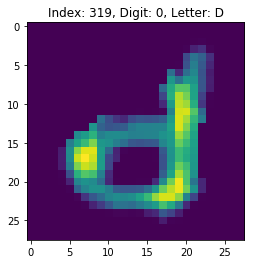

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   2  24  35   3   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  57  94  78  35   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1  64 107  71  28   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   90  30  91 116  65  20   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  132  94 133 128  67  22   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

In [97]:
idx = 319
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

for n, i in enumerate(img):
    for m, j in enumerate(i):
        if img[n][m] < 20:
            img[n][m] = img[n][m]/5
        


plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

print(img)

## Train model

In [98]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
'''
for img in x_train:
    for n, i in enumerate(img):
        for m, j in enumerate(i):
            if img[n][m] < 20:
                img[n][m] = img[n][m]
                '''

x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [99]:
x_val = x_train[-int(len(x_train)*0.2):]
y_val = y_train[-int(len(y_train)*0.2):]
x_train = x_train[:-int(len(x_train)*0.2)]
y_train = y_train[:-int(len(y_train)*0.2)]

In [100]:
print(str(x_val.shape))
print(str(y_val.shape))
print(str(x_train.shape))
print(str(y_train.shape))

(409, 28, 28, 1)
(409, 10)
(1639, 28, 28, 1)
(1639, 10)


In [11]:
def create_cnn_model(x_train):
    inputs = tf.keras.layers.Input(x_train.shape[1:])

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128,kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model
    
model = create_cnn_model(x_train)

In [109]:
num_classes = 10

model = Sequential([
  layers.Input(x_train.shape[1:]),

  layers.BatchNormalization(),
  layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.25),

  layers.BatchNormalization(),
  layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
  layers.BatchNormalization(),
  layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.25),

  layers.Flatten(),

  layers.BatchNormalization(),
  layers.Dense(1000, activation='relu', kernel_initializer='he_normal',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
  
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax', kernel_initializer= 'glorot_normal')
])

In [96]:
num_classes = 10

model = Sequential([

  layers.Input(x_train.shape[1:]),
  
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.BatchNormalization(),
  layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
  layers.Dense(num_classes, activation='softmax', kernel_initializer= 'glorot_normal')
])

In [92]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    # featurewise_center=True,
    featurewise_std_normalization=True,
    # width_shift_range=0.2,
    # height_shift_range=0.2
    )

In [111]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
    )

In [112]:
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_accuracy:.4f}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', verbose=1, save_best_only = True)

In [113]:
epochs=40
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=[cb_checkpoint])

Train on 1639 samples, validate on 409 samples
Epoch 1/40
1600/1639 [============================>.] - ETA: 0s - loss: 33.1861 - accuracy: 0.3925
Epoch 00001: val_accuracy improved from -inf to 0.30318, saving model to ./model/01-0.3032-31.2984.hdf5
1639/1639 [==============================] - 6s 3ms/sample - loss: 33.1241 - accuracy: 0.3960 - val_loss: 31.2984 - val_accuracy: 0.3032
Epoch 2/40
1600/1639 [============================>.] - ETA: 0s - loss: 25.6979 - accuracy: 0.5869
Epoch 00002: val_accuracy did not improve from 0.30318
1639/1639 [==============================] - 3s 2ms/sample - loss: 25.6006 - accuracy: 0.5882 - val_loss: 28.1004 - val_accuracy: 0.1076
Epoch 3/40
1600/1639 [============================>.] - ETA: 0s - loss: 18.1853 - accuracy: 0.6800
Epoch 00003: val_accuracy did not improve from 0.30318
1639/1639 [==============================] - 3s 2ms/sample - loss: 18.1131 - accuracy: 0.6797 - val_loss: 23.1606 - val_accuracy: 0.1076
Epoch 4/40
1632/1639 [=========

In [74]:
epochs=20
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    validation_data=(x_val, y_val), 
    epochs = epochs,
    callbacks=[cb_checkpoint])

NameError: name 'datagen' is not defined

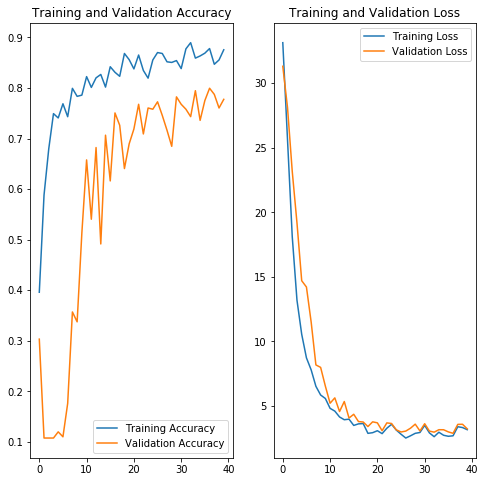

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict

In [115]:
model = keras.models.load_model('./model/30-0.7824-3.0689.hdf5')

In [116]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,1
3,2052,0
4,2053,3


In [117]:
submission.to_csv('08271349(regularization_val_0.7824).csv', index=False)